In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
# %%%%% FUNCTIONS_def %%%%%

# function  to discritize the segments into bins based on their length and node density

def discretize_and_save(data, output_prefix):
    kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    data['node_density_bins'] = kbd.fit_transform(data[['node_density']])

    for group_key, group_data in data.groupby('node_density_bins'):
        group_data.to_csv(f'{output_prefix}_{int(group_key)}.csv', index=False)


def assign_true_label(row):
  if 'MYS_mgr' in row['label']:
    return 1
  elif 'MYS_hgr' in row['label']:
    return 0
  else:
    return 999




from shapely import wkt
from shapely.geometry import LineString
from geopy.distance import geodesic
import numpy as np

def calculate_distances(wkt_string):
    """Calculates distances between consecutive points in a LineString."""
    line = wkt.loads(wkt_string)
    points = list(line.coords)
    distances = []
    for i in range(len(points) - 1):
        point1 = points[i]
        point2 = points[i + 1]
        distance = geodesic(point1[::-1], point2[::-1]).kilometers
        distances.append(distance)
    return distances

In [ ]:
# Loading the reference Dataset from Gdrive

Data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/Ref_dataset_Malashyia2.csv")

Control = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OSM_Changeset/Control_Data_MYS.csv")

Data['true_label'] = Data.apply(assign_true_label, axis=1)

# Print the updated DataFrame with the 'classification' column
display(Data.head())
# display(Control.head())

,hashtags,editor,user_id,tags,tags_before,key_highway,road_edit,road_length,contrib_type,wkt_geometry,...,country_iso_a3,wkt_centroid,lon,lat,n_vertices,node_density,year,month,label,true_label
0,[],JOSM/1.5 (13500 en),8925021,"{'key': ['highway'], 'value': ['service']}","{'key': [], 'value': []}",service,1.0,39,CREATED,"LINESTRING (110.34813079999999 1.5333171, 110....",...,['MYS'],POINT (110.34801848311409 1.533188688761092),110.348018,1.533189,4,0.102564,2018,11,MYS_hgr,0
1,['change' 'maproulette'],JOSM/1.5 (15390 en),9421520,"{'key': ['highway', 'surface'], 'value': ['tra...","{'key': [], 'value': []}",track,1.0,189,CREATED,"LINESTRING (101.778803 2.7998033, 101.7788739 ...",...,['MYS'],POINT (101.779564799762 2.799561302887499),101.779565,2.799561,23,0.121693,2019,12,MYS_hgr,0
2,[],iD 2.15.5,3553413,"{'key': ['highway'], 'value': ['service']}","{'key': [], 'value': []}",service,1.0,92,CREATED,"LINESTRING (103.87247959999999 2.3915506, 103....",...,['MYS'],POINT (103.87216239029067 2.39128561162369),103.872162,2.391286,4,0.043478,2019,9,MYS_hgr,0
3,[],JOSM/1.5 (13576 en),741163,"{'key': ['highway'], 'value': ['residential']}","{'key': [], 'value': []}",residential,1.0,391,CREATED,"LINESTRING (103.66470919999999 1.6128652, 103....",...,['MYS'],POINT (103.66593094314999 1.61159369341295),103.665931,1.611594,5,0.012788,2018,4,MYS_hgr,0
4,[],JOSM/1.5 (13576 Debian en),11030823,"{'key': ['highway'], 'value': ['residential']}","{'key': [], 'value': []}",residential,1.0,38,CREATED,"LINESTRING (102.8005852 1.918406, 102.80065069...",...,['MYS'],POINT (102.80063738409079 1.918567755586667),102.800637,1.918568,3,0.078947,2020,6,MYS_hgr,0


In [ ]:
# Count how many rows are from each source
source_counts = Control['label'].value_counts()
print("Count of rows by source:")
print(source_counts)

Count of rows by source:
label
1    396433
0    391799
Name: count, dtype: int64


In [ ]:
# Calculate distances for each LineString
Data['distances'] = Data['wkt_geometry'].apply(calculate_distances)

# Calculate average and standard deviation of distances
Data['avg_distance'] = Data['distances'].apply(np.mean)
Data['std_distance'] = Data['distances'].apply(np.std)
Data['cv_distance'] = Data['std_distance'] / Data['avg_distance']  # Coefficient of Variation

In [ ]:
# Step 1:  Bin the AI data based on node density using percentiles

# Calculate percentiles on the cleaned DataFrame to avoid NaNs
Data['density_bin'] = pd.cut(Data['node_density'], bins=np.percentile(Data['node_density'], [0, 25, 50, 75, 100]), labels=False, duplicates='drop')

kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

In [ ]:
# Step 1:  Bin the AI data based on node density using percentiles

# Calculate percentiles on the cleaned DataFrame to avoid NaNs
Control['density_bin'] = pd.cut(Control['node_density'], bins=np.percentile(Control['node_density'], [0, 25, 50, 75, 100]), labels=False, duplicates='drop')

kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

In [ ]:
# Step 2: Discretize AI node density into bins of natural breaks using percentiles
discretize_and_save(Data, 'OSM_mys')

# Fit KBinsDiscretizer on AI data
kbd.fit(Data[['node_density']])

KBinsDiscretizer(encode='ordinal')

In [ ]:
# Step 2: Discretize AI node density into bins of natural breaks using percentiles
discretize_and_save(Control, 'Ctrl_mys')

# Fit KBinsDiscretizer on AI data
kbd.fit(Control[['node_density']])

KBinsDiscretizer(encode='ordinal')

In [ ]:
# Step 3: Use the fitted KBinsDiscretizer on mixed data
Control['node_density_bins'] = kbd.transform(Control[['node_density']])

In [ ]:
best_percentiles_per_bin = {
    0.0: 0.8,
    1.0: 0.8,
    2.0: 0.2,
    3.0: 0.2,
    4.0: 0.9
}

# Classify instances within each bin using the optimal percentiles
predictions = []
for group_key, group_data in Data.groupby('node_density_bins'):
    best_percentile = best_percentiles_per_bin.get(group_key, 0.4)  # Use 0.4 as a default if the bin is not found
    threshold = group_data['node_density'].quantile(best_percentile)

    # Predict for instances in the current bin
    bin_predictions = (group_data['node_density'] > threshold).astype(int)
    predictions.extend(bin_predictions)

# Add the predicted labels to the DataFrame
Data['predicted_label'] = predictions

# Evaluate performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics using the entire dataset's true labels and the newly generated predicted labels
accuracy = accuracy_score(Data['true_label'], Data['predicted_label'])
precision = precision_score(Data['true_label'], Data['predicted_label'])
recall = recall_score(Data['true_label'], Data['predicted_label'])
f1 = f1_score(Data['true_label'], Data['predicted_label'])

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.58695
Precision: 0.6060107290904657
Recall: 0.49705
F1-score: 0.5461487748599055


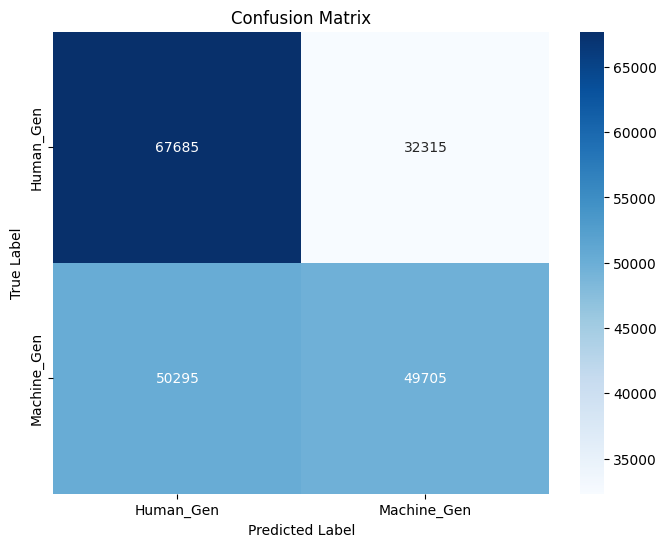

In [ ]:
# Plot the confusion matrix using Seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_matrix = confusion_matrix(Data['true_label'], Data['predicted_label'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human_Gen', 'Machine_Gen'],
            yticklabels=['Human_Gen', 'Machine_Gen'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Bin 0.0: Best Percentile: 0.1 with AUC: 0.51
Bin 1.0: Best Percentile: 0.9 with AUC: 0.52
Bin 2.0: Best Percentile: 0.9 with AUC: 0.56
Bin 3.0: Best Percentile: 0.7 with AUC: 0.63
Bin 4.0: Best Percentile: 0.8 with AUC: 0.55


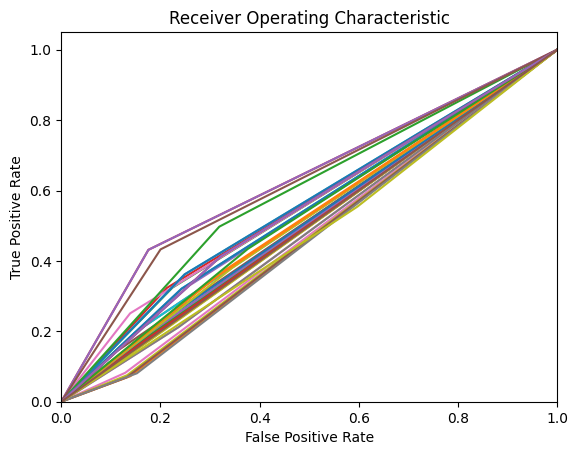

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

percentiles = np.arange(0.1, 1.0, 0.1)
plt.figure()

for group_key, group_data in Control.groupby('node_density_bins'):
    auc_scores = []
    for percentile in percentiles:
        # Calculate thresholds within the current bin
        threshold_low = group_data['node_density'].quantile(percentile - 0.1)
        threshold_high = group_data['node_density'].quantile(percentile)

        # Classify instances within the current bin
        y_pred = np.where(
            (group_data['node_density'] >= threshold_low) & (group_data['node_density'] <= threshold_high),
            1,
            0
        )

        # Calculate ROC curve and AUC score for the current bin
        fpr, tpr, _ = roc_curve(group_data['label'], y_pred)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)

        plt.plot(fpr, tpr, label=f'Bin {group_key}, Percentile: {percentile:.1f} (AUC = {roc_auc:.2f})')

    # Find the best percentile for the current bin
    best_percentile_bin = percentiles[np.argmax(auc_scores)]
    print(f"Bin {group_key}: Best Percentile: {best_percentile_bin:.1f} with AUC: {np.max(auc_scores):.2f}")

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
# plt.legend(loc="best")
plt.show()

In [ ]:
best_percentiles_per_bin = {
    0.0: 0.1,
    1.0: 0.1,
    2.0: 0.2,
    3.0: 0.8,
    4.0: 0.5
}

# Classify instances within each bin using the optimal percentiles
predictions = []
for group_key, group_data in Control.groupby('node_density_bins'):
    best_percentile = best_percentiles_per_bin.get(group_key, 0.4)  # Use 0.4 as a default if the bin is not found
    threshold = group_data['node_density'].quantile(best_percentile)

    # Predict for instances in the current bin
    bin_predictions = (group_data['node_density'] > threshold).astype(int)
    predictions.extend(bin_predictions)

# Add the predicted labels to the DataFrame
Control['predicted_label'] = predictions

# Evaluate performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics using the entire dataset's true labels and the newly generated predicted labels
accuracy = accuracy_score(Control['label'], Control['predicted_label'])
precision = precision_score(Control['label'], Control['predicted_label'])
recall = recall_score(Control['label'], Control['predicted_label'])
f1 = f1_score(Control['label'], Control['predicted_label'])

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7418247419541455
Precision: 0.6960238645346274
Recall: 0.8640072849636635
F1-score: 0.7709713868981165


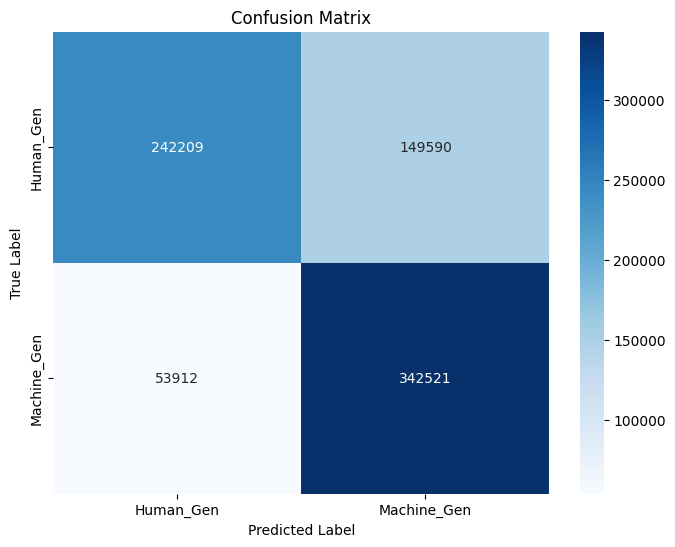

In [ ]:
# Plot the confusion matrix using Seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_matrix = confusion_matrix(Control['label'], Control['predicted_label'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human_Gen', 'Machine_Gen'],
            yticklabels=['Human_Gen', 'Machine_Gen'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Using percentile for thresholding

<ipython-input-54-a3784e6cc5ff>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UGC_data_bin['classification'] = np.where(
<ipython-input-54-a3784e6cc5ff>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UGC_data_bin['classification'] = np.where(
<ipython-input-54-a3784e6cc5ff>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Confusion Matrix:
[[24375 39666]
 [ 9097 56843]]
Accuracy: 0.6248451696786453
Precision: 0.5889917002559347
Recall: 0.8620412496208675
F1-score: 0.6998257914791719


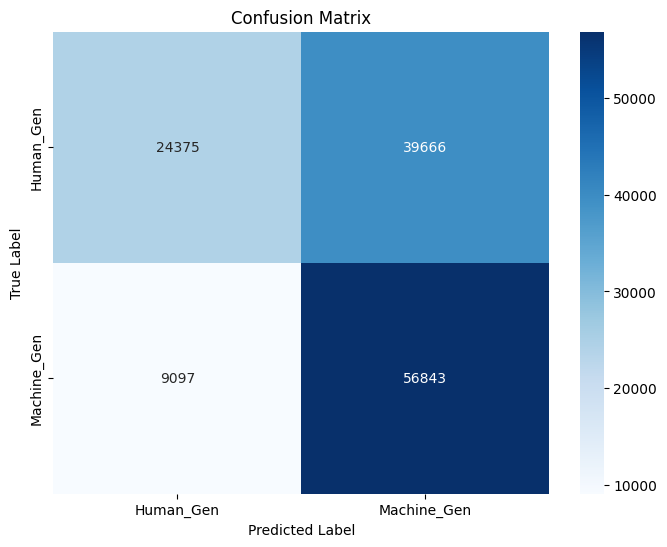

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Step 4 and 5: Iterate through bins and classify
MGC_bin_stats = Control.groupby('density_bin')['node_density'].agg(['mean', 'std']).reset_index()
for group_key, group_data in MGC_bin_stats.groupby('density_bin'):
    UGC_data_bin = Control[Control['node_density_bins'] == group_key]

    # Calculate thresholds based on quantiles
    threshold_low = UGC_data_bin['node_density'].quantile(0.25)
    threshold_high = UGC_data_bin['node_density'].quantile(0.75)

    UGC_data_bin['classification'] = np.where(
        (UGC_data_bin['node_density'] >= threshold_low) & (UGC_data_bin['node_density'] <= threshold_high), 1, 0)



#Evaluation

y_true = UGC_data_bin['label']
y_pred = UGC_data_bin['classification']

confusion_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_matrix)


# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human_Gen', 'Machine_Gen'],
            yticklabels=['Human_Gen', 'Machine_Gen'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-71-94b76412adad>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UGC_data_bin['classification'] = np.where(
<ipython-input-71-94b76412adad>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UGC_data_bin['classification'] = np.where(
<ipython-input-71-94b76412adad>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Confusion Matrix:
[[15653 18341]
 [ 8938  7066]]
Accuracy: 0.4543981759270371
Precision: 0.27811233124729406
Recall: 0.44151462134466385
F1-score: 0.3412619835309459


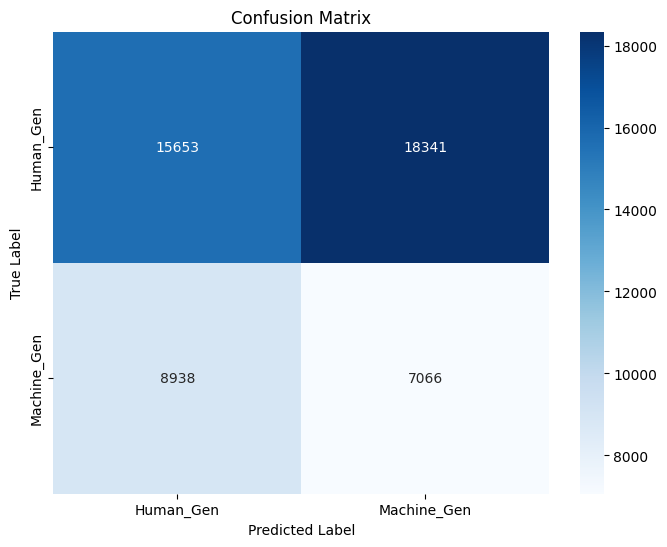

In [ ]:
#Predicitog the reference data for each node density bin

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Step 4 and 5: Iterate through bins and classify
MGC_bin_stats = Data.groupby('density_bin')['node_density'].agg(['mean', 'std']).reset_index()
for group_key, group_data in MGC_bin_stats.groupby('density_bin'):
    UGC_data_bin = Data[Data['density_bin'] == group_key]

    # Calculate thresholds based on quantiles
    threshold_low = UGC_data_bin['node_density'].quantile(0.25)
    threshold_high = UGC_data_bin['node_density'].quantile(0.75)

    UGC_data_bin['classification'] = np.where(
        (UGC_data_bin['node_density'] >= threshold_low) & (UGC_data_bin['node_density'] <= threshold_high), 1, 0)



#Evaluation

y_true = UGC_data_bin['true_label']
y_pred = UGC_data_bin['classification']

confusion_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_matrix)


# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human_Gen', 'Machine_Gen'],
            yticklabels=['Human_Gen', 'Machine_Gen'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Step 1:  Bin the AI data based on node density using percentiles
MGC['density_bin'] = pd.cut(MGC['node_density'], bins=np.percentile(ai_data['node_density'], [0, 25, 50, 75, 100]), labels=False)

kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

# %%
# Step 2: Discretize AI node density into bins of natural breaks using percentiles
discretize_and_save(MGG, 'AI_NaturalBreaks')

# Fit KBinsDiscretizer on AI data
kbd.fit(MGC[['node_density']])
# %%

# Step 3: Use the fitted KBinsDiscretizer on mixed data
UGC['node_density_bins'] = kbd.transform(UGC[['node_density']])

MGC_bin_stats = Data.groupby('density_bin')['node_density'].agg(['mean', 'std']).reset_index()

for group_key, group_data in MGC_bin_stats.iterrows(): # Iterate through MGC_bin_stats instead of Data
    #UGC_data_bin = MGC_bin_stats[Data['node_density_bins'] == group_key] # This line is redundant

    # Access 'mean' and 'std' directly from group_data
    threshold_low = group_data['mean'] - 2 * group_data['std']
    threshold_high = group_data['mean'] + 2 * group_data['std']

    # Filter Data based on density_bin and apply classification
    UGC_data_bin = Data[Data['density_bin'] == group_key]
    UGC_data_bin['classification'] = np.where(
        (UGC_data_bin['node_density'] >= threshold_low) & (UGC_data_bin['node_density'] <= threshold_high),
        1,
        0
    )

<ipython-input-16-00221438b6ad>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UGC_data_bin['classification'] = np.where(
<ipython-input-16-00221438b6ad>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UGC_data_bin['classification'] = np.where(
<ipython-input-16-00221438b6ad>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Confusion Matrix:
[[ 1015 32979]
 [  906 15098]]
Accuracy: 0.3222728909156366
Precision: 0.31403789753936395
Recall: 0.943389152711822
F1-score: 0.47121611710179306


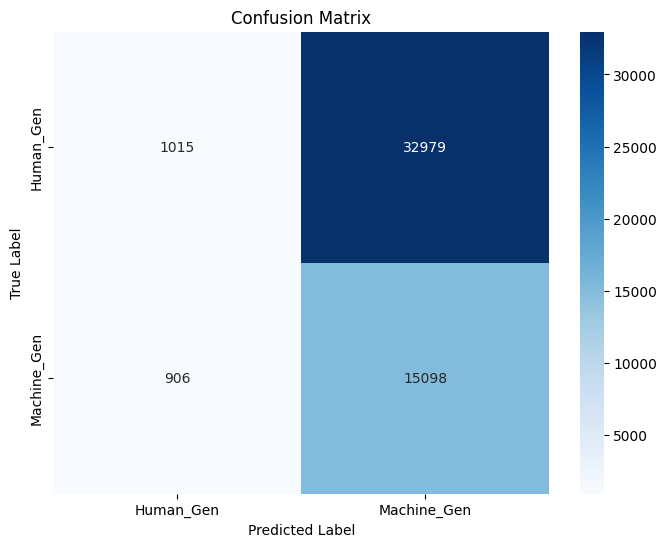

In [ ]:
#Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = UGC_data_bin['true_label']
y_pred = UGC_data_bin['classification']

confusion_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_matrix)


# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human_Gen', 'Machine_Gen'],
            yticklabels=['Human_Gen', 'Machine_Gen'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()